## Compare reference VMAF implementation and Pytorch version

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200
import seaborn as sns
sns.set()

import torch
import torch.nn.functional as F

from vmaf_torch import VMAF, VMAF_C, yuv_to_tensor, tensor_to_yuv

np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)

Check that elementary metrics values for frames are close (on one video) 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# load reference and distorted yuv as tensors

yuv_path_ref = "/storage/data/NFLX_dataset_public/ref/BigBuckBunny_25fps.yuv"
yuv_path_dist = "/storage/data/NFLX_dataset_public/dis/BigBuckBunny_20_288_375.yuv"

width = 1920
height = 1080
num_frames = 50   # using only first frames to avoid CUDA out of memory errors

ref_t = yuv_to_tensor(yuv_path_ref, width, height, num_frames)
ref_t = ref_t.to(device)

dist_t = yuv_to_tensor(yuv_path_dist, width, height, num_frames)
dist_t = dist_t.to(device)

ref_t.shape, dist_t.shape

(torch.Size([50, 1, 1080, 1920]), torch.Size([50, 1, 1080, 1920]))

In [4]:
# initialize VMAF Pytorch version
vmaf = VMAF(temporal_pooling=True, enable_motion=True, clip_score=True, NEG=False)
vmaf = vmaf.to(device)

In [5]:
# initialize VMAF C version
vmaf_executable = 'vmaf'       # linux
#vmaf_executable = 'vmaf.exe'  # windows
vmaf_model_version = "default"
#vmaf_model_version = "NEG"
vmaf_c = VMAF_C(vmaf_executable=vmaf_executable, vmaf_model_version=vmaf_model_version)  # wrapper class for vmaf executable

In [6]:
# run VMAF Pytorch version
df_torch = vmaf.table(ref_t, dist_t)
df_torch.head(10)

,Frame,integer_motion2,integer_motion,integer_adm2,integer_adm_scale0,integer_adm_scale1,integer_adm_scale2,integer_adm_scale3,integer_vif_scale0,integer_vif_scale1,integer_vif_scale2,integer_vif_scale3,vmaf
0,0,0.0,0.0,0.734756,0.815721,0.59479,0.62329,0.8353,0.252368,0.483596,0.61275,0.718086,21.099077
1,1,13.879902,13.879902,0.725233,0.811577,0.584113,0.605981,0.827939,0.253677,0.480951,0.605354,0.706255,31.332096
2,2,13.960742,13.960742,0.742847,0.815371,0.592279,0.629449,0.850794,0.270983,0.516105,0.6502,0.756837,36.952862
3,3,14.113519,14.113519,0.734082,0.81754,0.58816,0.616737,0.837131,0.267854,0.504399,0.632607,0.734851,34.348751
4,4,14.192772,14.192772,0.743509,0.820687,0.597746,0.630377,0.847964,0.276937,0.524252,0.657939,0.763557,37.611664
5,5,14.270576,14.270576,0.73409,0.817889,0.5897,0.619923,0.834732,0.272443,0.508238,0.635047,0.736776,34.535984
6,6,14.340849,14.340849,0.746379,0.819898,0.596499,0.639694,0.848329,0.280918,0.527029,0.659885,0.765659,38.32378
7,7,14.413815,14.413815,0.735486,0.821692,0.593816,0.618585,0.836395,0.274136,0.508464,0.634241,0.735734,34.818417
8,8,14.477407,14.482537,0.7453,0.823099,0.600414,0.632306,0.846213,0.283457,0.528409,0.659878,0.763821,38.122269
9,9,14.426366,14.477407,0.736964,0.821989,0.594767,0.62465,0.83214,0.278252,0.513779,0.639408,0.740542,35.299511


In [7]:
# run VMAF executable and read resulting csv table
df_C = vmaf_c.table_from_path(yuv_path_ref, yuv_path_dist, width, height, num_frames)
# rename some volumns so both tables have same column names
df_C = df_C.rename(columns={s:s.removesuffix('_egl_1') for s in df_C.columns}).drop(columns='Unnamed: 13') # for NEG version
df_C = df_C.rename(columns={s:'integer_'+s if 'integer_'not in s else s for s in df_C.columns if (s!='Frame') and (s!='vmaf')})         # for float version
df_C.head(10)

Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/BigBuckBunny_25fps.yuv -d /storage/data/NFLX_dataset_public/dis/BigBuckBunny_20_288_375.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 -b 8 --threads 16 -q --csv -o vmaf_out.csv 
Reading: vmaf_out.csv


,Frame,integer_motion2,integer_motion,integer_adm2,integer_adm_scale0,integer_adm_scale1,integer_adm_scale2,integer_adm_scale3,integer_vif_scale0,integer_vif_scale1,integer_vif_scale2,integer_vif_scale3,vmaf
0,0,0.000000,0.000000,0.734757,0.815733,0.594801,0.623285,0.835292,0.252377,0.483606,0.612775,0.718224,21.106428
1,1,13.879942,13.879942,0.725233,0.811572,0.584101,0.605993,0.827931,0.253683,0.480981,0.605464,0.706234,31.332317
2,2,13.960780,13.960780,0.742848,0.815400,0.592274,0.629442,0.850788,0.270979,0.516117,0.650251,0.756875,36.955908
3,3,14.113557,14.113557,0.734084,0.817564,0.588164,0.616730,0.837124,0.267857,0.504417,0.632604,0.734903,34.351827
4,4,14.192812,14.192812,0.743503,0.820688,0.597720,0.630370,0.847957,0.276937,0.524267,0.657976,0.763615,37.613729
5,5,14.270615,14.270615,0.734087,0.817891,0.589695,0.619919,0.834723,0.272444,0.508210,0.635091,0.736792,34.537279
6,6,14.340888,14.340888,0.746377,0.819909,0.596479,0.639690,0.848323,0.280929,0.527048,0.659919,0.765735,38.328358
7,7,14.413856,14.413856,0.735485,0.821702,0.593810,0.618579,0.836389,0.274142,0.508470,0.634260,0.735820,34.822351
8,8,14.477447,14.482575,0.745297,0.823104,0.600409,0.632296,0.846206,0.283462,0.528433,0.659925,0.763922,38.127711
9,9,14.426404,14.477447,0.736963,0.822000,0.594758,0.624646,0.832133,0.278251,0.513806,0.639499,0.740640,35.306566


In [8]:
df_difference = df_torch-df_C
df_difference.head(10)

,Frame,integer_motion2,integer_motion,integer_adm2,integer_adm_scale0,integer_adm_scale1,integer_adm_scale2,integer_adm_scale3,integer_vif_scale0,integer_vif_scale1,integer_vif_scale2,integer_vif_scale3,vmaf
0,0,0.0,0.0,-0.000001,-0.000012,-0.000011,0.000005,0.000008,-0.000009,-0.00001,-0.000025,-0.000138,-0.007351
1,0,-0.00004,-0.00004,0.0,0.000005,0.000012,-0.000012,0.000008,-0.000006,-0.00003,-0.00011,0.000021,-0.000221
2,0,-0.000038,-0.000038,-0.000001,-0.000029,0.000005,0.000007,0.000006,0.000004,-0.000012,-0.000051,-0.000038,-0.003046
3,0,-0.000038,-0.000038,-0.000002,-0.000024,-0.000004,0.000007,0.000007,-0.000003,-0.000018,0.000003,-0.000052,-0.003076
4,0,-0.00004,-0.00004,0.000006,-0.000001,0.000026,0.000007,0.000007,0.0,-0.000015,-0.000037,-0.000058,-0.002065
5,0,-0.000039,-0.000039,0.000003,-0.000002,0.000005,0.000004,0.000009,-0.000001,0.000028,-0.000044,-0.000016,-0.001295
6,0,-0.000039,-0.000039,0.000002,-0.000011,0.00002,0.000004,0.000006,-0.000011,-0.000019,-0.000034,-0.000076,-0.004578
7,0,-0.000041,-0.000041,0.000001,-0.00001,0.000006,0.000006,0.000006,-0.000006,-0.000006,-0.000019,-0.000086,-0.003934
8,0,-0.00004,-0.000038,0.000003,-0.000005,0.000005,0.00001,0.000007,-0.000005,-0.000024,-0.000047,-0.000101,-0.005442
9,0,-0.000038,-0.00004,0.000001,-0.000011,0.000009,0.000004,0.000007,0.000001,-0.000027,-0.000091,-0.000098,-0.007055


In [9]:
# compute average difference
df_difference.abs().mean()

Frame                      0.0
integer_motion2       0.000037
integer_motion        0.000037
integer_adm2          0.000006
integer_adm_scale0    0.000017
integer_adm_scale1    0.000018
integer_adm_scale2    0.000009
integer_adm_scale3    0.000008
integer_vif_scale0    0.000007
integer_vif_scale1    0.000017
integer_vif_scale2    0.000037
integer_vif_scale3    0.000065
vmaf                  0.003779
dtype: object

Check that VMAF values for videos are close on a dataset 

In [10]:
# to download Netflix public dataset see https://github.com/Netflix/vmaf/blob/master/resource/doc/datasets.md

dataset_name = 'NFLX_public'
yuv_fmt = 'yuv420p'
width = 1920
height = 1080

ref_dir = '/storage/data/NFLX_dataset_public/ref'
dis_dir = '/storage/data/NFLX_dataset_public/dis'

In [11]:
# dataset metadata from https://github.com/Netflix/vmaf/blob/master/resource/dataset/NFLX_dataset_public.py
ref_videos = [
 {'content_id': 0,
  'content_name': 'BigBuckBunny',
  'path': ref_dir + '/BigBuckBunny_25fps.yuv'},
 {'content_id': 1,
  'content_name': 'BirdsInCage',
  'path': ref_dir + '/BirdsInCage_30fps.yuv'},
 {'content_id': 2,
  'content_name': 'CrowdRun',
  'path': ref_dir + '/CrowdRun_25fps.yuv'},
 {'content_id': 3,
  'content_name': 'ElFuente1',
  'path': ref_dir + '/ElFuente1_30fps.yuv'},
 {'content_id': 4,
  'content_name': 'ElFuente2',
  'path': ref_dir + '/ElFuente2_30fps.yuv'},
 {'content_id': 5,
  'content_name': 'FoxBird',
  'path': ref_dir + '/FoxBird_25fps.yuv'},
 {'content_id': 6,
  'content_name': 'OldTownCross',
  'path': ref_dir + '/OldTownCross_25fps.yuv'},
 {'content_id': 7,
  'content_name': 'Seeking',
  'path': ref_dir + '/Seeking_25fps.yuv'},
 {'content_id': 8,
  'content_name': 'Tennis',
  'path': ref_dir + '/Tennis_24fps.yuv'}
]

dis_videos = [{'asset_id': 0,
  'content_id': 0,
  'dmos': 100.0,
  'path': ref_dir + '/BigBuckBunny_25fps.yuv',
 },
 {'asset_id': 1,
  'content_id': 1,
  'dmos': 100.0,
  'path': ref_dir + '/BirdsInCage_30fps.yuv',
 },
 {'asset_id': 2,
  'content_id': 2,
  'dmos': 100.0,
  'path': ref_dir + '/CrowdRun_25fps.yuv',
 },
 {'asset_id': 3,
  'content_id': 3,
  'dmos': 100.0,
  'path': ref_dir + '/ElFuente1_30fps.yuv',
 },
 {'asset_id': 4,
  'content_id': 4,
  'dmos': 100.0,
  'path': ref_dir + '/ElFuente2_30fps.yuv',
 },
 {'asset_id': 5,
  'content_id': 5,
  'dmos': 100.0,
  'path': ref_dir + '/FoxBird_25fps.yuv',
 },
 {'asset_id': 6,
  'content_id': 6,
  'dmos': 100.0,
  'path': ref_dir + '/OldTownCross_25fps.yuv',
 },
 {'asset_id': 7,
  'content_id': 7,
  'dmos': 100.0,
  'path': ref_dir + '/Seeking_25fps.yuv',
 },
 {'asset_id': 8,
  'content_id': 8,
  'dmos': 100.0,
  'path': ref_dir + '/Tennis_24fps.yuv',
 },
 {'asset_id': 9,
  'content_id': 0,
  'dmos': 22.5,
  'path': dis_dir + '/BigBuckBunny_20_288_375.yuv',
 },
 {'asset_id': 10,
  'content_id': 0,
  'dmos': 35.0,
  'path': dis_dir + '/BigBuckBunny_30_384_550.yuv',
 },
 {'asset_id': 11,
  'content_id': 0,
  'dmos': 49.166666666666664,
  'path': dis_dir + '/BigBuckBunny_40_384_750.yuv',
 },
 {'asset_id': 12,
  'content_id': 0,
  'dmos': 61.666666666666664,
  'path': dis_dir + '/BigBuckBunny_50_480_1050.yuv',
 },
 {'asset_id': 13,
  'content_id': 0,
  'dmos': 78.333333333333329,
  'path': dis_dir + '/BigBuckBunny_55_480_1750.yuv',
 },
 {'asset_id': 14,
  'content_id': 0,
  'dmos': 97.5,
  'path': dis_dir + '/BigBuckBunny_75_720_3050.yuv',
 },
 {'asset_id': 15,
  'content_id': 0,
  'dmos': 95.0,
  'path': dis_dir + '/BigBuckBunny_80_720_4250.yuv',
 },
 {'asset_id': 16,
  'content_id': 0,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/BigBuckBunny_85_1080_3800.yuv',
 },
 {'asset_id': 17,
  'content_id': 0,
  'dmos': 103.33333333333333,
  'path': dis_dir + '/BigBuckBunny_90_1080_4300.yuv',
 },
 {'asset_id': 18,
  'content_id': 0,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/BigBuckBunny_95_1080_5800.yuv',
 },
 {'asset_id': 19,
  'content_id': 1,
  'dmos': 38.333333333333336,
  'path': dis_dir + '/BirdsInCage_40_288_375.yuv',
 },
 {'asset_id': 20,
  'content_id': 1,
  'dmos': 40.0,
  'path': dis_dir + '/BirdsInCage_50_288_550.yuv',
 },
 {'asset_id': 21,
  'content_id': 1,
  'dmos': 52.5,
  'path': dis_dir + '/BirdsInCage_60_384_550.yuv',
 },
 {'asset_id': 22,
  'content_id': 1,
  'dmos': 55.0,
  'path': dis_dir + '/BirdsInCage_65_384_750.yuv',
 },
 {'asset_id': 23,
  'content_id': 1,
  'dmos': 70.0,
  'path': dis_dir + '/BirdsInCage_80_480_750.yuv',
 },
 {'asset_id': 24,
  'content_id': 1,
  'dmos': 92.5,
  'path': dis_dir + '/BirdsInCage_85_720_1050.yuv',
 },
 {'asset_id': 25,
  'content_id': 1,
  'dmos': 100.83333333333333,
  'path': dis_dir + '/BirdsInCage_90_1080_1800.yuv',
 },
 {'asset_id': 26,
  'content_id': 1,
  'dmos': 102.5,
  'path': dis_dir + '/BirdsInCage_95_1080_3000.yuv',
 },
 {'asset_id': 27,
  'content_id': 2,
  'dmos': 20.0,
  'path': dis_dir + '/CrowdRun_03_288_375.yuv',
 },
 {'asset_id': 28,
  'content_id': 2,
  'dmos': 40.0,
  'path': dis_dir + '/CrowdRun_40_480_2350.yuv',
 },
 {'asset_id': 29,
  'content_id': 2,
  'dmos': 58.333333333333336,
  'path': dis_dir + '/CrowdRun_50_1080_4300.yuv',
 },
 {'asset_id': 30,
  'content_id': 2,
  'dmos': 67.5,
  'path': dis_dir + '/CrowdRun_65_1080_5800.yuv',
 },
 {'asset_id': 31,
  'content_id': 2,
  'dmos': 81.666666666666671,
  'path': dis_dir + '/CrowdRun_75_1080_7500.yuv',
 },
 {'asset_id': 32,
  'content_id': 2,
  'dmos': 85.0,
  'path': dis_dir + '/CrowdRun_80_1080_10000.yuv',
 },
 {'asset_id': 33,
  'content_id': 2,
  'dmos': 94.166666666666671,
  'path': dis_dir + '/CrowdRun_90_1080_15000.yuv',
 },
 {'asset_id': 34,
  'content_id': 3,
  'dmos': 18.333333333333332,
  'path': dis_dir + '/ElFuente1_10_288_375.yuv',
 },
 {'asset_id': 35,
  'content_id': 3,
  'dmos': 29.166666666666668,
  'path': dis_dir + '/ElFuente1_25_384_750.yuv',
 },
 {'asset_id': 36,
  'content_id': 3,
  'dmos': 66.666666666666671,
  'path': dis_dir + '/ElFuente1_50_480_1750.yuv',
 },
 {'asset_id': 37,
  'content_id': 3,
  'dmos': 72.5,
  'path': dis_dir + '/ElFuente1_60_720_2350.yuv',
 },
 {'asset_id': 38,
  'content_id': 3,
  'dmos': 86.666666666666671,
  'path': dis_dir + '/ElFuente1_70_1080_4300.yuv',
 },
 {'asset_id': 39,
  'content_id': 3,
  'dmos': 95.0,
  'path': dis_dir + '/ElFuente1_85_1080_5800.yuv',
 },
 {'asset_id': 40,
  'content_id': 3,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/ElFuente1_90_1080_7500.yuv',
 },
 {'asset_id': 41,
  'content_id': 4,
  'dmos': 25.0,
  'path': dis_dir + '/ElFuente2_05_288_375.yuv',
 },
 {'asset_id': 42,
  'content_id': 4,
  'dmos': 55.0,
  'path': dis_dir + '/ElFuente2_30_480_1750.yuv',
 },
 {'asset_id': 43,
  'content_id': 4,
  'dmos': 58.333333333333336,
  'path': dis_dir + '/ElFuente2_50_720_3050.yuv',
 },
 {'asset_id': 44,
  'content_id': 4,
  'dmos': 68.333333333333329,
  'path': dis_dir + '/ElFuente2_60_1080_4300.yuv',
 },
 {'asset_id': 45,
  'content_id': 4,
  'dmos': 75.833333333333329,
  'path': dis_dir + '/ElFuente2_65_720_4250.yuv',
 },
 {'asset_id': 46,
  'content_id': 4,
  'dmos': 82.5,
  'path': dis_dir + '/ElFuente2_70_1080_5800.yuv',
 },
 {'asset_id': 47,
  'content_id': 4,
  'dmos': 93.333333333333329,
  'path': dis_dir + '/ElFuente2_80_1080_10000.yuv',
 },
 {'asset_id': 48,
  'content_id': 4,
  'dmos': 96.666666666666671,
  'path': dis_dir + '/ElFuente2_85_1080_15000.yuv',
 },
 {'asset_id': 49,
  'content_id': 4,
  'dmos': 97.5,
  'path': dis_dir + '/ElFuente2_90_1080_20000.yuv',
 },
 {'asset_id': 50,
  'content_id': 5,
  'dmos': 34.166666666666664,
  'path': dis_dir + '/FoxBird_20_288_375.yuv',
 },
 {'asset_id': 51,
  'content_id': 5,
  'dmos': 60.0,
  'path': dis_dir + '/FoxBird_40_384_750.yuv',
 },
 {'asset_id': 52,
  'content_id': 5,
  'dmos': 64.166666666666671,
  'path': dis_dir + '/FoxBird_55_480_750.yuv',
 },
 {'asset_id': 53,
  'content_id': 5,
  'dmos': 83.333333333333329,
  'path': dis_dir + '/FoxBird_65_480_1750.yuv',
 },
 {'asset_id': 54,
  'content_id': 5,
  'dmos': 90.833333333333329,
  'path': dis_dir + '/FoxBird_80_1080_2300.yuv',
 },
 {'asset_id': 55,
  'content_id': 5,
  'dmos': 101.66666666666667,
  'path': dis_dir + '/FoxBird_95_1080_5800.yuv',
 },
 {'asset_id': 56,
  'content_id': 6,
  'dmos': 30.833333333333332,
  'path': dis_dir + '/OldTownCross_20_288_375.yuv',
 },
 {'asset_id': 57,
  'content_id': 6,
  'dmos': 45.0,
  'path': dis_dir + '/OldTownCross_45_384_750.yuv',
 },
 {'asset_id': 58,
  'content_id': 6,
  'dmos': 57.5,
  'path': dis_dir + '/OldTownCross_55_480_750.yuv',
 },
 {'asset_id': 59,
  'content_id': 6,
  'dmos': 75.0,
  'path': dis_dir + '/OldTownCross_60_480_1750.yuv',
 },
 {'asset_id': 60,
  'content_id': 6,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/OldTownCross_80_720_2350.yuv',
 },
 {'asset_id': 61,
  'content_id': 6,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/OldTownCross_85_720_2950.yuv',
 },
 {'asset_id': 62,
  'content_id': 6,
  'dmos': 109.16666666666667,
  'path': dis_dir + '/OldTownCross_90_1080_4300.yuv',
 },
 {'asset_id': 63,
  'content_id': 7,
  'dmos': 19.166666666666668,
  'path': dis_dir + '/Seeking_10_288_375.yuv',
 },
 {'asset_id': 64,
  'content_id': 7,
  'dmos': 41.666666666666664,
  'path': dis_dir + '/Seeking_30_480_1050.yuv',
 },
 {'asset_id': 65,
  'content_id': 7,
  'dmos': 50.833333333333336,
  'path': dis_dir + '/Seeking_45_480_1750.yuv',
 },
 {'asset_id': 66,
  'content_id': 7,
  'dmos': 66.666666666666671,
  'path': dis_dir + '/Seeking_50_720_2350.yuv',
 },
 {'asset_id': 67,
  'content_id': 7,
  'dmos': 75.833333333333329,
  'path': dis_dir + '/Seeking_60_720_3050.yuv',
 },
 {'asset_id': 68,
  'content_id': 7,
  'dmos': 80.833333333333329,
  'path': dis_dir + '/Seeking_65_1080_4300.yuv',
 },
 {'asset_id': 69,
  'content_id': 7,
  'dmos': 91.666666666666671,
  'path': dis_dir + '/Seeking_75_1080_5800.yuv',
 },
 {'asset_id': 70,
  'content_id': 7,
  'dmos': 90.0,
  'path': dis_dir + '/Seeking_85_1080_7500.yuv',
 },
 {'asset_id': 71,
  'content_id': 7,
  'dmos': 91.666666666666671,
  'path': dis_dir + '/Seeking_90_1080_15000.yuv',
 },
 {'asset_id': 72,
  'content_id': 7,
  'dmos': 96.666666666666671,
  'path': dis_dir + '/Seeking_95_1080_20000.yuv',
 },
 {'asset_id': 73,
  'content_id': 8,
  'dmos': 33.333333333333336,
  'path': dis_dir + '/Tennis_20_288_375.yuv',
 },
 {'asset_id': 74,
  'content_id': 8,
  'dmos': 50.0,
  'path': dis_dir + '/Tennis_40_384_750.yuv',
 },
 {'asset_id': 75,
  'content_id': 8,
  'dmos': 71.666666666666671,
  'path': dis_dir + '/Tennis_60_480_1050.yuv',
 },
 {'asset_id': 76,
  'content_id': 8,
  'dmos': 68.333333333333329,
  'path': dis_dir + '/Tennis_70_480_1750.yuv',
 },
 {'asset_id': 77,
  'content_id': 8,
  'dmos': 94.166666666666671,
  'path': dis_dir + '/Tennis_80_720_3050.yuv',
 },
 {'asset_id': 78,
  'content_id': 8,
  'dmos': 99.166666666666671,
  'path': dis_dir + '/Tennis_90_1080_4300.yuv',
 }]


In [12]:
num_frames = 50   # using only first frames to avoid CUDA out of memory errors

c_vmaf_scores = []
torch_vmaf_scores = []

feature_names = ['integer_motion2', 'integer_motion', 'integer_adm2',
'integer_adm_scale0', 'integer_adm_scale1', 'integer_adm_scale2',
'integer_adm_scale3', 'integer_vif_scale0', 'integer_vif_scale1',
'integer_vif_scale2', 'integer_vif_scale3']

c_features = {f_n:[] for f_n in feature_names}
torch_features = {f_n:[] for f_n in feature_names}

for vid in dis_videos:
    yuv_path_dist = vid['path']
    yuv_path_ref = [d['path'] for d in ref_videos if d['content_id']==vid['content_id']][0]
    
    df_C = vmaf_c.table_from_path(yuv_path_ref, yuv_path_dist, width, height, num_frames)
    df_C = df_C.rename(columns={s:s.removesuffix('_egl_1') for s in df_C.columns}).drop(columns='Unnamed: 13') # for NEG version
    df_C = df_C.rename(columns={s:'integer_'+s if 'integer_'not in s else s for s in df_C.columns if (s!='Frame') and (s!='vmaf')}) # for float version
    c_score = df_C['vmaf'].mean()
    c_vmaf_scores.append(c_score)
    
    ref_t = yuv_to_tensor(yuv_path_ref, width, height, num_frames)
    ref_t = ref_t.to(device)
    dist_t = yuv_to_tensor(yuv_path_dist, width, height, num_frames)
    dist_t = dist_t.to(device)
    with torch.no_grad():
        #torch_score = vmaf(ref_t, dist_t).item()
        df_torch = vmaf.table(ref_t, dist_t)
    torch_score = df_torch['vmaf'].mean()
    torch_vmaf_scores.append(torch_score)
    
    for f_n in feature_names:
        c_features[f_n].extend(df_C[f_n].to_list())
        torch_features[f_n].extend(df_torch[f_n].to_list())

Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/BigBuckBunny_25fps.yuv -d /storage/data/NFLX_dataset_public/ref/BigBuckBunny_25fps.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 -b 8 --threads 16 -q --csv -o vmaf_out.csv 
Reading: vmaf_out.csv
Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/BirdsInCage_30fps.yuv -d /storage/data/NFLX_dataset_public/ref/BirdsInCage_30fps.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 -b 8 --threads 16 -q --csv -o vmaf_out.csv 
Reading: vmaf_out.csv
Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/CrowdRun_25fps.yuv -d /storage/data/NFLX_dataset_public/ref/CrowdRun_25fps.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 -b 8 --threads 16 -q --csv -o vmaf_out.csv 
Reading: vmaf_out.csv
Executing: vmaf -r /storage/data/NFLX_dataset_public/ref/ElFuente1_30fps.yuv -d /storage/data/NFLX_dataset_public/ref/ElFuente1_30fps.yuv -w 1920 -h 1080 --frame_cnt 50 -p 420 -b 8 --threads 16 -q --csv -o vmaf_out.csv 
Reading: vmaf_out.csv
Executing: vmaf -r /stor

In [13]:
c_scores = np.array(c_vmaf_scores)
torch_scores = np.array(torch_vmaf_scores)

print(c_scores)
print(torch_scores)

[99.94856 98.25662 99.94856 99.94855 99.94857 98.66826 99.94856 99.94857
 99.94855 38.77267 53.45405 59.57528 71.26628 79.80366 92.59078 95.89494
 99.36421 99.64995 99.72615 47.8713  49.20007 61.95285 62.95595 73.04774
 83.67003 92.03811 93.10625  9.50615 45.24235 67.25528 75.8502  82.62579
 88.94848 95.46937 18.96033 34.78473 59.81088 71.02117 87.90463 94.42793
 98.31813  8.17311 27.51911 38.36571 43.87356 45.95208 52.97681 70.6065
 84.31544 92.40967 23.62585 47.11207 56.70465 69.9516  90.85483 96.77523
 24.15121 44.36051 56.5914  62.48474 79.74344 80.52022 93.08052 14.99169
 38.1423  49.40092 58.76257 65.61184 76.02255 83.90921 90.03208 98.87703
 99.5548  48.70014 66.91183 77.35461 83.50241 92.32154 97.5599 ]
[99.94855 98.25633 99.94857 99.94852 99.94856 98.6682  99.94856 99.94858
 99.94855 38.76918 53.44974 59.57076 71.26163 79.79903 92.58531 95.89039
 99.36157 99.64983 99.72594 47.86439 49.19118 61.94929 62.95972 73.03864
 83.66441 92.03106 93.10261  9.50634 45.24839 67.2621  75.85

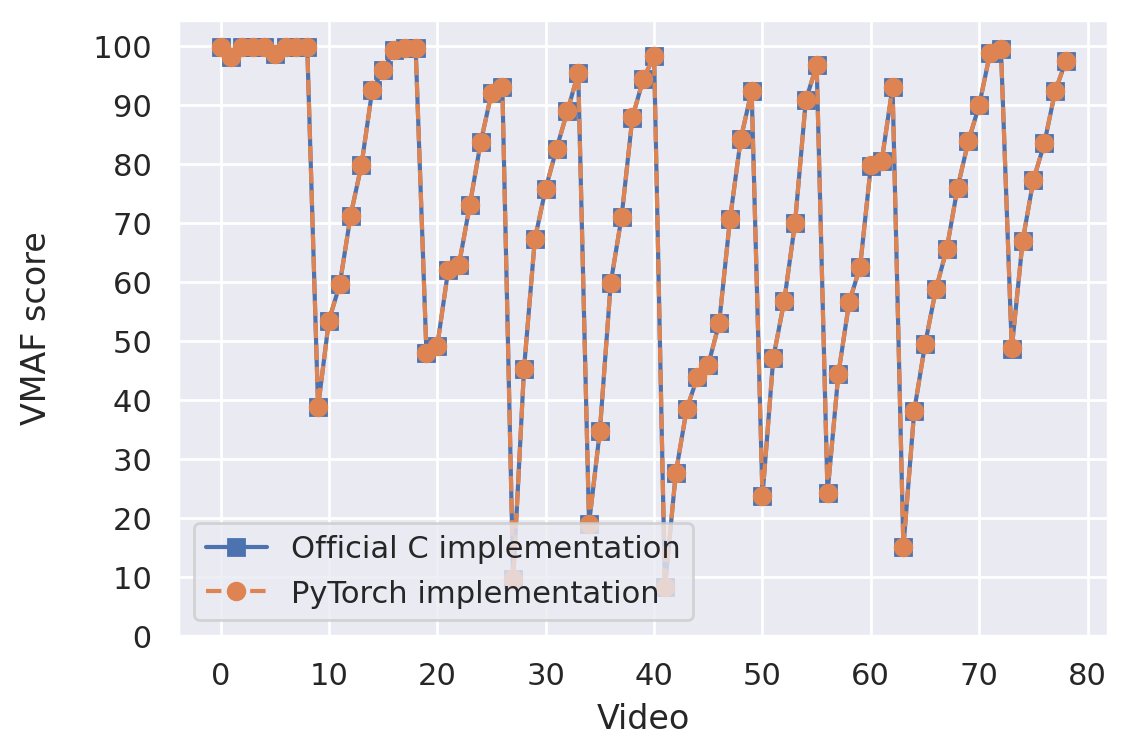

In [18]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(79), c_scores, 's-', label='Official C implementation')
plt.plot(np.arange(79), torch_scores, 'o--', label='PyTorch implementation')
plt.xlabel('Video')
plt.ylabel('VMAF score')
plt.yticks(np.arange(0,101, 10), labels=[str(x).rjust(6, ' ') for x in np.arange(0,101, 10)])  # make both plots the same size
plt.legend(loc=3)

In [16]:
dif = np.abs(torch_scores - c_scores)
dif

array([0.00001, 0.00029, 0.00001, 0.00004, 0.     , 0.00007, 0.00001,
       0.00001, 0.     , 0.00349, 0.00431, 0.00452, 0.00465, 0.00464,
       0.00547, 0.00455, 0.00264, 0.00012, 0.00021, 0.00691, 0.00889,
       0.00357, 0.00377, 0.00911, 0.00562, 0.00705, 0.00364, 0.00019,
       0.00604, 0.00683, 0.00626, 0.00806, 0.00571, 0.00599, 0.00209,
       0.00318, 0.00269, 0.00352, 0.00262, 0.00229, 0.0021 , 0.00098,
       0.00106, 0.00141, 0.00036, 0.00189, 0.00323, 0.00503, 0.00862,
       0.0062 , 0.00053, 0.00197, 0.00198, 0.00498, 0.00407, 0.00082,
       0.01926, 0.02269, 0.02664, 0.02512, 0.02664, 0.02589, 0.02721,
       0.0002 , 0.00216, 0.0023 , 0.0026 , 0.00265, 0.00298, 0.00266,
       0.0032 , 0.0011 , 0.00036, 0.02435, 0.0236 , 0.02334, 0.02073,
       0.02158, 0.00941])

Text(0, 0.5, 'Absolute difference in VMAF scores')

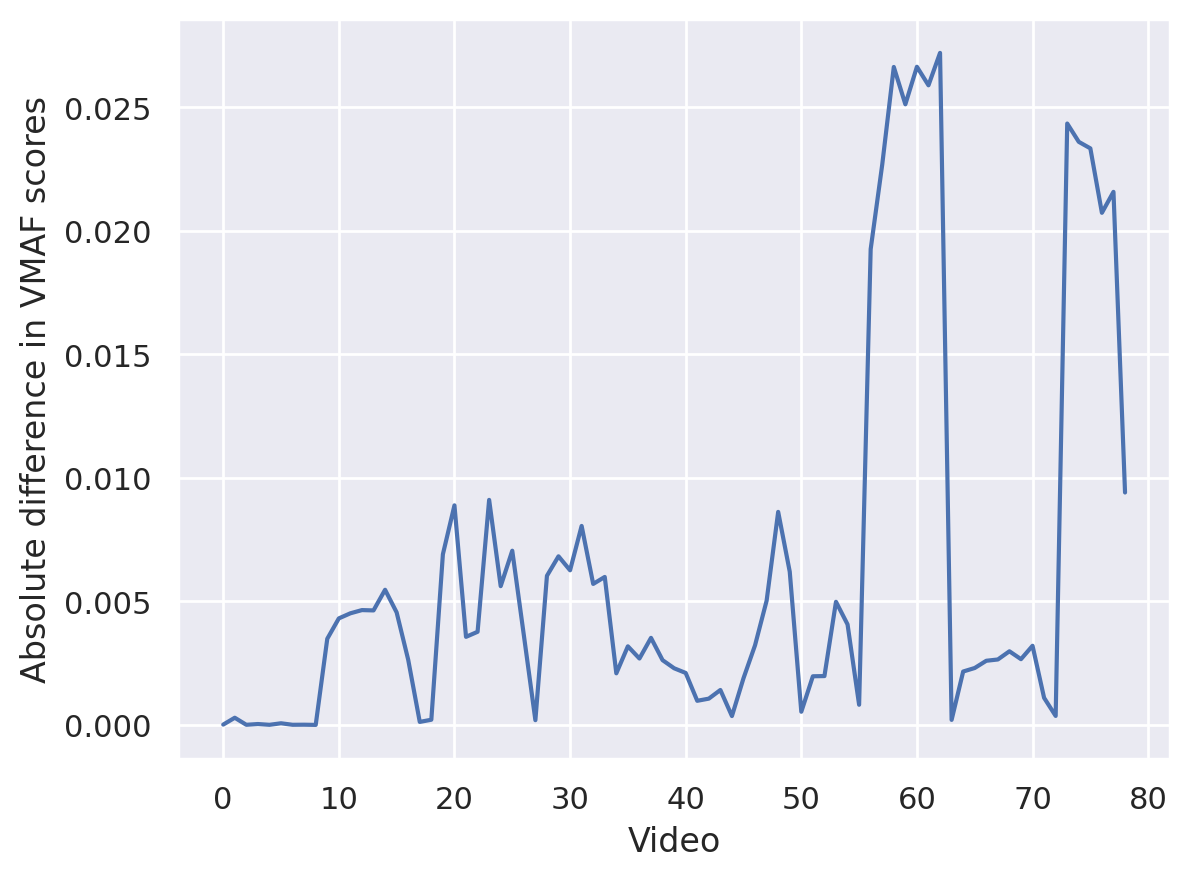

In [19]:
plt.plot(np.arange(79), dif)
plt.xlabel('Video')
plt.ylabel('Absolute difference in VMAF scores')


In [20]:
dif.mean(), dif.std(), dif.min(), dif.max()

(0.0063415146650974965,
 0.007872519084080359,
 8.701367164576368e-07,
 0.02720559372069431)

In [21]:
for f_n in feature_names:
    f_dif = np.abs(np.array(c_features[f_n]) - np.array(torch_features[f_n]))
    print(f_n, f_dif.mean())

integer_motion2 2.10227016120057e-05
integer_motion 2.0914144144141918e-05
integer_adm2 6.742017304140894e-06
integer_adm_scale0 1.4823751319208265e-05
integer_adm_scale1 1.4953979398993844e-05
integer_adm_scale2 1.168075469583722e-05
integer_adm_scale3 8.810439298604325e-06
integer_vif_scale0 2.9370299166002973e-05
integer_vif_scale1 3.162750494196396e-05
integer_vif_scale2 5.1258400964131346e-05
integer_vif_scale3 0.00010490992777425858
